In [3]:
if 'RAN_PIP' not in globals():
    !pip install wandb matplotlib tokenizers
    RAN_PIP = True

In [4]:
#----- imports --------

import tqdm
import torch
from torch import nn
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 2e-3,
    "sae_learning_rate": 5e-5,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 128,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v

! wandb disabled

wandb.init(
   project = "outlier-exploration",
   config = config,
)
torch.backends.cuda.matmul.allow_tf32 = True

W&B disabled.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


In [5]:
# stories_data = []
# data_dir = './data'
# for filename in os.listdir(data_dir):
#     file_path = os.path.join(data_dir, filename)
#     if filename.endswith('.json'):
#         with open(file_path, 'r', encoding='utf-8') as f:
#             data = json.load(f)
#             stories_data.extend(data)

In [6]:
# # load the tinystories tokenizer
# tokenizer = tokenizers.ByteLevelBPETokenizer(
#     "./tiny-stories-bpe-vocab.json", 
#     "./tiny-stories-bpe-merges.txt"
# )

# def encode(text):
#     return torch.tensor(tokenizer.encode(text).ids, dtype=torch.int64)
# def decode(encoded_text):
#     return tokenizer.decode(encoded_text.tolist())

# from tqdm import tqdm

# encoded_stories = [encode(story['story']) for story in tqdm(stories_data, desc="Encoding stories")]

In [7]:
# # save the encoded stories to a file
# torch.save(encoded_stories, 'encoded-stories.pt')

In [8]:

with open('tinystories-train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [9]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1922767089


In [10]:
1916206969/4

479051742.25

In [11]:
print("length of dataset in lines: ", len(text.split('\n')))

length of dataset in lines:  14815490


In [12]:
print(text[:1000])

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
<|endoftext|>
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.
One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were

In [13]:
# paths = ['tinystories-train.txt']
# tokenizer = tokenizers.ByteLevelBPETokenizer()

# tokenizer.train(files=paths, vocab_size=tokenizer_vocab_size, min_frequency=2)

# tokenizer.save_model('.', 'tiny-stories-bpe')



# enc = tokenizer.encode("She sells sea shells by the sea shore!")
# tokenizer.decode(enc.ids)



In [14]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)


In [15]:

def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

from tqdm import tqdm

def batch_encode(text, batch_size):
    tokens = []
    for i in tqdm(range(0, len(text), batch_size)):
        tokens.extend(encode(text[i:i+batch_size]))
    return tokens


hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)

[6099]
hello
vocab size:  8192


In [16]:
sample_text = text[:200000]
sample_encoded = batch_encode(sample_text, 20000)

# get the amount of memory used by sample_encoded
def recursive_memory_usage(python_obj):
    if isinstance(python_obj, (str, int, float)):
        return python_obj.__sizeof__()
    if isinstance(python_obj, dict):
        return sum([recursive_memory_usage(v) for v in python_obj.values()])
    if isinstance(python_obj, list):
        return sum([recursive_memory_usage(v) for v in python_obj])
    return python_obj.__sizeof__()

print("memory used by sample_encoded: ", recursive_memory_usage(sample_encoded) / 1024**2, "MB")


100%|██████████| 10/10 [00:00<00:00, 82.00it/s]

memory used by sample_encoded:  1.2849769592285156 MB


In [17]:
print("length of dataset in characters: ", len(text[:10000]))
print("length of dataset in tokens: ", len(encode(text[:10000])))
chars_per_token = len(text[:10000]) / len(encode(text[:10000]))
print("characters per token: ", chars_per_token)

length of dataset in characters:  10000
length of dataset in tokens:  2440
characters per token:  4.098360655737705


In [18]:
# encoded_text = batch_encode(text, 200000)
# # data = torch.tensor(encode(text), dtype=torch.int64)
# data = torch.tensor(encoded_text, dtype=torch.int64, device='cuda')
# print(data.dtype)
# print(data.size())
# print(data.device)
# torch.save(data, 'tiny-stories-train.pt')
# encoded_text = None


In [19]:
# load data from tiny-stories-train.pt
data = torch.load('tiny-stories-train.pt', map_location='cuda')


In [20]:
len(data)

468163695

In [21]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [22]:
train_data.size()

torch.Size([421347325])

In [23]:
train_data[:T+1]

tensor([ 427,  357,   11,  258,  405,  452,  507,  365,  600,  258, 3729,  316,
         308,  763,   13,  312,  708,  303,  281, 2965,  265,  360,  342,  303,
         792,  303,  281, 2120,   13,  365,  450,  265,  953,  262, 3729,  342,
         308,  367,   11,  350,  338,  466, 5179,  258, 2227,  345,  308, 2498,
          13,  198,  343,  475,  265,  308,  367,  264,  326,   11,  328,  775,
          11,  335,  600,  745, 3729,   13, 1283,  346,  953,  303,  342,  525,
         264, 5179,  656, 2498,  484,  870,  367,  505,  264,  326,   11,  328,
         835,   11,  365,   11,  368,  478,  953,  262, 3729,  264, 1307,  633,
        2498,  421,  198, 4611,   11,  364, 1658,  262, 3729,  264, 7866,  262,
        2227,  345,  365,  374, 2498,   13,  415,  281,  393, 2965,  369,  454,
         792,  364,  435, 2500,  264, 1763,  761,  576,   13, 1454,  364, 1444,
          11,  365,  863,  308,  367,  369, 2500,  262, 3729,  264, 5132,  308,
        2498,   13,  320,  900,  520,  4

In [24]:
decode(train_data[:T+1].cpu().numpy())

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.\n<|endoftext|>\nOnce upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves th

In [25]:
x = train_data[:T]
y = train_data[1:T+1]
for t in range(T):
    context = x[:t+1]
    target = y[t]
    # print("when we see the text", context, "we predict the next character is", target)

In [26]:
# torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [27]:

import torch
import torch.nn as nn
from torch.nn import functional as F
# torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)


In [28]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return x

In [29]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([128, 256, 32])

In [30]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
        )

    def forward(self, x):
        return self.net(x)

In [31]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [32]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [33]:
class GPT(nn.Module):

    def __init__(self, n_layers):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
    
    def forward(self, idx, targets=None, return_residuals=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        if return_residuals == "first_embedding":
            return x

        def excess_kurtosis(emb):
            mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
            std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

            centralized = emb - mean #BxTxC
            fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
            kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
            # view as a 1d vector
            kurtosis = kurtosis.view(-1) - 3
            # make each one min 0
            kurtosis = torch.maximum(kurtosis, torch.tensor(0.0))
            # sum over the vector
            kurtosis = torch.sum(kurtosis)
            return kurtosis


        kurtosis_sum = torch.tensor(0.0)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            kurtosis_sum += excess_kurtosis(x)
            if return_residuals is not None and i == return_residuals:
                return x
        
        kurtosis_avg = kurtosis_sum / (len(self.layers) * T * B)
        # kurtosis_avg = torch.tensor(0.0)

        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        if targets is None:
            return logits, None, kurtosis_avg
        else:
            # a list of all the predictions, reguardles of batch.
            # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
            # ydim: all predictions for all batches flattened (batch_dim*sequence_dim)
            logits_loss_view = logits.view(-1, vocab_size) 
            # targets loss view
            # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
            # so this would be like, [1,4,5,1,2,3, ...]
            # where each number is the correct next index of the one hot vector
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            return logits, loss, kurtosis_avg

    def generate(self, idx, max_new_tokens, temperature=0.5):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] # all batches, last token, all probabilities
            # apply temperature
            last_token_logits = last_token_logits / temperature
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    def prompt_model(self, prompt, max_new_tokens, temperature=0.5):
        autoregressive_seq = encode(prompt)
        for _ in range(max_new_tokens):
            prediction_index = len(autoregressive_seq)-1

            model_input = torch.tensor(autoregressive_seq)
            
            while model_input.shape[0] < T:
                pad_token = torch.tensor(encode("\n"))
                model_input = torch.cat((model_input, pad_token), dim=0)

            model_input
            model_input = model_input.unsqueeze(0)

            logits, loss, kurtosis_avg = model(model_input)
            prediction_token = logits[:, prediction_index, :] / temperature
            probabilities = F.softmax(prediction_token, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            autoregressive_seq.append(next_token)
        # get the autoregressive sequence
        return decode(autoregressive_seq)
    def get_embedding(self, prompt, override_model_embedding_layer=None):
        if override_model_embedding_layer is None:
            selected_model_embedding_layer = model_embedding_layer
        else:
            selected_model_embedding_layer = override_model_embedding_layer
        sequence = encode(prompt)
        model_input = torch.tensor(sequence)
        sequence_index = len(sequence) - 1
        while model_input.shape[0] < T:
            pad_token = torch.tensor(encode("\n"))
            model_input = torch.cat((model_input, pad_token), dim=0)
        model_input = model_input.unsqueeze(0)
        embedding = self.forward(model_input, return_residuals=selected_model_embedding_layer)
        # remove the batch dimension
        embedding = embedding.squeeze(0)[sequence_index]
        return embedding



    

model = GPT(n_layers)
# logits, loss, kurtosis_avg = model(xb, yb)
# print(logits.shape)
# print(loss)
# print(kurtosis_avg)




test_idx = torch.zeros(1, T).long()
model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

(tensor([[[-0.1197, -0.3722, -0.3019,  ..., -2.0665, -0.7800,  0.6276],
          [-0.8917,  0.3750,  0.1270,  ..., -1.7355, -1.4034, -0.3043],
          [ 0.8081, -0.0899, -0.1531,  ..., -1.1997,  0.1534,  1.3117],
          ...,
          [-0.4933,  0.3355,  0.0908,  ...,  0.1013, -0.0234,  0.4200],
          [ 1.8602, -0.5551, -0.1798,  ..., -1.1878, -0.6923,  0.1932],
          [ 0.2719,  0.6074,  0.6580,  ..., -1.8934, -0.6459,  0.2747]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 None,
 tensor(0.0372, device='cuda:0', grad_fn=<DivBackward0>))

In [34]:
model

GPT(
  (token_embedding_table): Embedding(8192, 256)
  (position_embedding_table): Embedding(256, 256)
  (lm_head): Linear(in_features=256, out_features=8192, bias=True)
  (layers): ModuleList(
    (0-11): 12 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (query): Linear(in_features=256, out_features=32, bias=False)
            (key): Linear(in_features=256, out_features=32, bias=False)
            (value): Linear(in_features=256, out_features=32, bias=False)
          )
        )
        (combine_heads): Linear(in_features=256, out_features=256, bias=True)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=768, bias=True)
          (1): ReLU()
          (2): Linear(in_features=768, out_features=256, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
    )
  )
)

In [35]:
# get the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of parameters in the model: ", count_parameters(model))

number of parameters in the model:  12160000


In [36]:
data.shape

torch.Size([468163695])

In [37]:
# logits, loss = self(idx[:,-T:])

idx = torch.zeros(1, 1).long()
idx[:,-T:]

tensor([[0]], device='cuda:0')

In [38]:
model.token_embedding_table.weight.device

device(type='cuda', index=0)

In [39]:
eval_iters = 10
eval_interval = 300
@torch.no_grad()
def estimate_loss(is_last=False):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        real_iters = eval_iters
        if is_last and split == 'val':  # increase last eval to mitigate noise
            real_iters *= 10 
        losses = torch.zeros(real_iters)
        for k in range(real_iters):
            X, Y = get_batch(split)
            logits, loss, kurtosis_avg = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean() / chars_per_token
    model.train()
    return out
    

In [40]:
# get the number of parameters
n_params = sum(p.numel() for p in model.parameters())
parameter_to_data_ratio = n_params / len(train_data)
print(f"{parameter_to_data_ratio=}")

parameters = []
for name, param in model.named_parameters():
    parameters.append({"name": name, "params": param.numel()})

# sort parameters by size
sorted_parameters = sorted(parameters, key=lambda x: x["params"], reverse=True)
for p in sorted_parameters:
    print(f"{p['name']}: {p['params']}")

parameter_to_data_ratio=0.02885980111538622
token_embedding_table.weight: 2097152
lm_head.weight: 2097152
layers.0.ff.net.0.weight: 196608
layers.0.ff.net.2.weight: 196608
layers.1.ff.net.0.weight: 196608
layers.1.ff.net.2.weight: 196608
layers.2.ff.net.0.weight: 196608
layers.2.ff.net.2.weight: 196608
layers.3.ff.net.0.weight: 196608
layers.3.ff.net.2.weight: 196608
layers.4.ff.net.0.weight: 196608
layers.4.ff.net.2.weight: 196608
layers.5.ff.net.0.weight: 196608
layers.5.ff.net.2.weight: 196608
layers.6.ff.net.0.weight: 196608
layers.6.ff.net.2.weight: 196608
layers.7.ff.net.0.weight: 196608
layers.7.ff.net.2.weight: 196608
layers.8.ff.net.0.weight: 196608
layers.8.ff.net.2.weight: 196608
layers.9.ff.net.0.weight: 196608
layers.9.ff.net.2.weight: 196608
layers.10.ff.net.0.weight: 196608
layers.10.ff.net.2.weight: 196608
layers.11.ff.net.0.weight: 196608
layers.11.ff.net.2.weight: 196608
position_embedding_table.weight: 65536
layers.0.attention.combine_heads.weight: 65536
layers.1.att

In [41]:
train_logs = []

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# "learning_rate": 2e-3,

import tqdm
num_params = sum([p.numel() for p in model.parameters()])
save_steps = 1500

for steps in tqdm.tqdm(range(max_iters)):
    xb, yb = get_batch('train')
    # loss
    logits, loss, kurtosis_avg = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    # l2 regularization
    # l2 = sum(p.pow(2).sum() for p in model.parameters()) / num_params
    wandb.log({'llm_loss':loss.item(), "kurtosis":kurtosis_avg.item()})
    # loss = loss + kurtosis_avg * 0.4/160
    loss.backward()
    optimizer.step()
    if steps % save_steps == 0:
        torch.save(model.state_dict(), f'models/adam-checkpoints/{steps}.pt')

    # if steps % eval_interval == 0:
    #     losses = estimate_loss()
    #     wandb.log({"tiain": losses['train'].item(), "val": losses['val'].item(), "l2":l2})
    #     # print({"tIain": losses['train'].item(), "val": losses['val'].item(), "kurtosis_avg": kurtosis_avg.item()})

losses = estimate_loss(is_last=True)
# wandb.log({"train": losses['train'].item(), "val": losses['val'].item()})
wandb.finish()


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 8/60000 [00:02<4:46:05,  3.49it/s] 


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('models/6000.pt'))


<All keys matched successfully>

In [ ]:
import torch

def random_rotation_matrix(n, dtype=torch.float32):
    """
    Generate a random rotation matrix in n dimensions.
    
    Args:
    n (int): Number of dimensions
    dtype (torch.dtype): Data type of the matrix
    device (str or torch.device): Device to create the matrix on
    
    Returns:
    torch.Tensor: An n x n random rotation matrix
    """
    # Generate a random matrix
    A = torch.randn(n, n, dtype=dtype)
    
    # Compute the QR factorization
    Q, R = torch.linalg.qr(A)
    
    # Ensure proper rotation matrix (determinant = 1)
    D = torch.diag(torch.sign(torch.diag(R)))
    Q = torch.mm(Q, D)
    
    return Q

rot = random_rotation_matrix(100)

(rot @ rot.T - torch.eye(100)).sum()


In [43]:
# Disable gradient tracking for the model
def excess_kurtosis(emb):
    mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
    std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

    centralized = emb - mean #BxTxC
    fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
    kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
    return kurtosis - 3

model.eval()
repeated_text = "Lilly saw a big red apple!"
stored_embeddings = {}
with torch.no_grad():
    for filename in os.listdir('models/adam-checkpoints/'):
        model_path = f"models/adam-checkpoints/{filename}"
        model.load_state_dict(torch.load(model_path))
        test_embedding = model.get_embedding(repeated_text)
        stored_embeddings[f"step {filename.split('.')[0]}"] = test_embedding
        
        

In [51]:
stored_embeddings['step 1500'].shape

torch.Size([256])

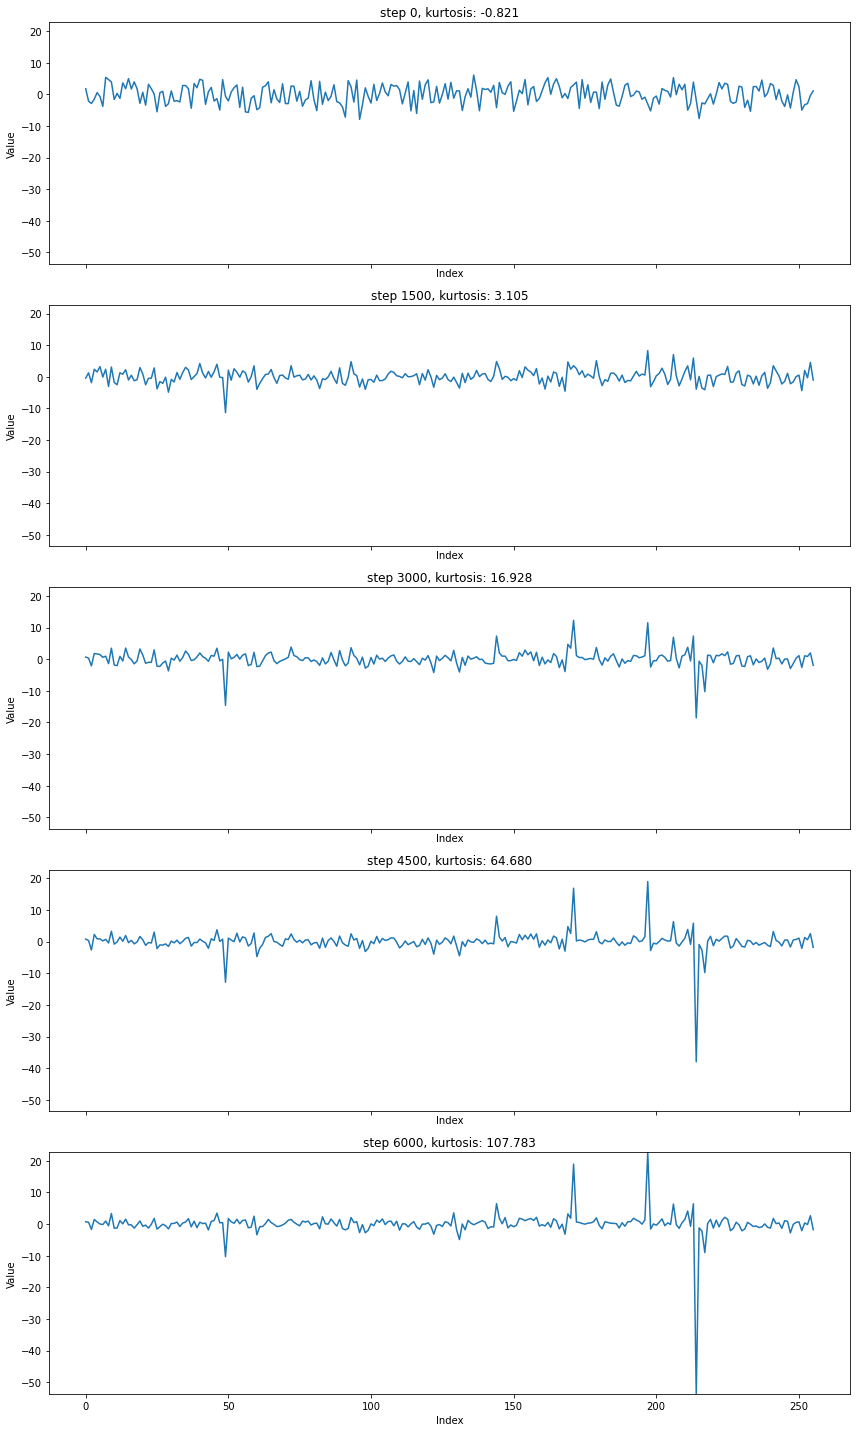

In [59]:
import matplotlib.pyplot as plt
import torch

# Assuming you have a dictionary with GPU tensors
gpu_tensor_dict = {
    'tensor1': torch.randn(100).cuda(),
    'tensor2': torch.randn(100).cuda(),
    'tensor3': torch.randn(100).cuda(),
    # Add more tensors as needed
}
gpu_tensor_dict = stored_embeddings

# Calculate the number of rows and columns for subplots
num_tensors = len(gpu_tensor_dict)
num_cols = 1  # You can adjust this
num_rows = (num_tensors + num_cols - 1) // num_cols

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Find global min and max values
all_values = torch.cat(list(gpu_tensor_dict.values()), dim=0)
global_min = all_values.min().item()
global_max = all_values.max().item()

# Plot each tensor
for idx, (key, tensor) in enumerate(gpu_tensor_dict.items()):
    # Move tensor to CPU and convert to numpy array
    excess_kurtosis_value = excess_kurtosis(tensor).item()
    cpu_tensor = tensor.cpu().numpy()
    
    # Plot on the corresponding subplot
    axes[idx].plot(cpu_tensor)
    axes[idx].set_title(f"{key}, kurtosis: {excess_kurtosis_value:.3f}")
    axes[idx].set_xlabel('Index')
    axes[idx].set_ylabel('Value')
    axes[idx].set_ylim(global_min, global_max)

# Remove any unused subplots
for idx in range(num_tensors, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [46]:
repeated_text = "Lilly saw a big red apple!"

model.load_state_dict(torch.load('models/6000.pt'))
text_embedding = model.get_embedding(repeated_text)

topk, topk_idxs = text_embedding.abs().topk(5)

topk_idxs

tensor([214, 197, 171,  49, 217], device='cuda:0')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


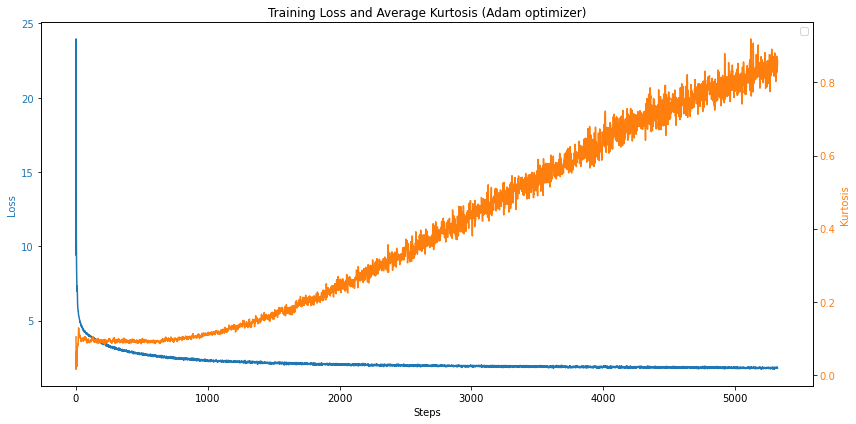

Final loss: 1.8262
Final kurtosis: 0.8614


In [ ]:
import matplotlib.pyplot as plt

# Extract loss and kurtosis values from train_logs
losses, kurtosis_values = zip(*train_logs)

# Create a figure with one plot and two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot loss on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(0, 16)

# Draw a horizontal line at loss=0.52
# ax1.axhline(y=0.52, color='r', linestyle='--', label='Loss = 0.52')

# Create a secondary y-axis for kurtosis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Kurtosis', color=color)
ax2.plot(kurtosis_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0, 70)

# Set the title and add legend
plt.title('Training Loss and Average Kurtosis (Adam optimizer)')
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print the final loss and kurtosis values
print(f"Final loss: {losses[-1]:.4f}")
print(f"Final kurtosis: {kurtosis_values[-1]:.4f}")

In [37]:
estimate_loss()

{'train': tensor(0.4782, device='cuda:0'),
 'val': tensor(0.4784, device='cuda:0')}

In [36]:
# save model
torch.save(model.state_dict(), 'models/tiny-stories-model-adam-new.pt')



In [ ]:
# load the model
# model.load_state_dict(torch.load('models/tiny-stories-model-SGD-0.52-loss.pt'))


<All keys matched successfully>

In [ ]:
print(model.prompt_model("<|endoftext|>\nOnce upon a time, there was a little boy", 200, 0.4))

<|endoftext|>
Once upon a time, there was a little boy named Timmy. Timmy loved to play with his toy cars and trucks. One day, Timmy's mom gave him a new toy car. It was a big red car with a red car. Timmy was very happy and played with his new toy cars all day long.
But then, Timmy's mom said, "Timmy, it's time to go home now." Timmy didn't want to leave his new car, but he knew his mom would be there soon. So, he went to his room and got his new car. He played with it all day long and had lots of fun. From that day on, Timmy always made sure to take his new car outside and keep it safe.
<|endoftext|>
Once upon a time, there was a little girl named Lily. She loved to play outside in the park with her friends. One day, they saw a big, ugly dog. The dog was very friendly and Lily wanted to pet it.
Lily said, "Please, please


# Kurtosis debugging

In [ ]:
story1='''Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it.
Roxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?"
Roxy told Billy about the icy hill and how she couldn't climb it'''

# assume BxTxC
def excess_kurtosis(emb):
    mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
    std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

    centralized = emb - mean #BxTxC
    fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
    kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
    return kurtosis - 3



emb1 = model.get_embedding("Tim and Lily saw a big dog", override_model_embedding_layer=6)
emb2 = model.get_embedding("Lilly and Tim noticed a cat", override_model_embedding_layer=6)


import matplotlib.pyplot as plt
import numpy as np



# Plot emb1 and emb2 in the same plot
# plt.figure(figsize=(10, 5))
# plt.plot(np.square(emb1.cpu().detach().numpy()), label='emb1', color='blue')
# plt.plot(np.square(emb2.cpu().detach().numpy()), label='emb2', color='red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('emb1 and emb2 Plot')
# plt.legend()
# plt.show()



# get the index of the highest value
# Assuming emb1 and emb2 are tensors
highest_value_index_emb1 = torch.argmax(emb1).item()
highest_value_index_emb2 = torch.argmax(emb2).item()

lowest_value_index_emb1 = torch.argmin(emb1).item()
lowest_value_index_emb2 = torch.argmin(emb2).item()

print(f"Index of the highest value in emb1: {highest_value_index_emb1}")
print(f"Index of the highest value in emb2: {highest_value_index_emb2}")
print(f"Index of the lowest value in emb1: {lowest_value_index_emb1}")
print(f"Index of the lowest value in emb2: {lowest_value_index_emb2}")

print(f"emb1 excess kurtosis: {excess_kurtosis(emb1)}")
print(f"emb2 excess kurtosis: {excess_kurtosis(emb2)}")

# dot product between emb1 and emb2
emb1_l2 = F.normalize(emb1, p=2, dim=-1)
emb2_l2 = F.normalize(emb2, p=2, dim=-1)
print(f"Dot product between emb1 and emb2: {torch.dot(emb1_l2, emb2_l2)}")



Index of the highest value in emb1: 239
Index of the highest value in emb2: 146
Index of the lowest value in emb1: 203
Index of the lowest value in emb2: 81
emb1 excess kurtosis: -0.31801652908325195
emb2 excess kurtosis: -0.1101229190826416
Dot product between emb1 and emb2: 0.8099309206008911


emb1 excess kurtosis: 157.1050262451172
emb2 excess kurtosis: 156.85986328125
when we load the model trained from this notebook, it has excess kurtosis of 157.1050262451172

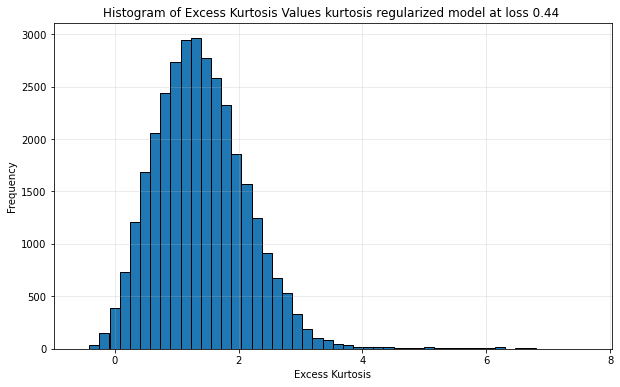

tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
xb, yb = get_batch('val')
emb = model.forward(xb, return_residuals=model_embedding_layer)

# emb.shape
kurtosis_values = excess_kurtosis(emb).view(-1)
import matplotlib.pyplot as plt

# Convert kurtosis values to CPU and numpy for plotting
kurtosis_np = kurtosis_values.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.hist(kurtosis_np, bins=50, edgecolor='black')
plt.xlabel('Excess Kurtosis')
plt.ylabel('Frequency')
plt.title('Histogram of Excess Kurtosis Values kurtosis regularized model at loss 0.44 ')
plt.grid(True, alpha=0.3)
plt.show()


print(kurtosis_values.mean())